## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [18]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import plot_precision_recall_curve
from tqdm import tqdm
plt.style.use("seaborn")

In [4]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)

# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [5]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Normalize data

In [6]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

## Compare hists between classes

In [7]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
#records0.hist(figsize=(20,20));

In [8]:
#records1.hist(figsize=(20,20));

In [9]:
print("Differences between fraud and non-fraud:")
for i in records0.keys():
    print("Differences in",i)
    print("Median:", records0[i].median()-records1[i].median())
    print("Mean:", records0[i].mean()-records1[i].mean())
    print("Std:", records0[i].std()-records1[i].std())
    
    print()

Differences between fraud and non-fraud:
Differences in Time
Median: 0.19252172971223316
Mean: 0.2967350075315986
Std: -0.007398674870575661

Differences in V1
Median: 1.2061703137691455
Mean: 2.4405046304538205
Std: -2.4781146185470924

Differences in V2
Median: -1.6070883853499391
Mean: -2.198286258857717
Std: -1.6078579173914733

Differences in V3
Median: 3.4673686501116703
Mean: 4.64661415234859
Std: -3.727280862082994

Differences in V4
Median: -2.966060774701858
Mean: -3.2134966851943867
Std: -1.041046096449672

Differences in V5
Median: 1.0646680521499936
Mean: 2.2870389213706708
Std: -2.9092742802983906

Differences in V6
Median: 0.8643081611514458
Mean: 1.050953871019782
Std: -0.3964738063666099

Differences in V7
Median: 2.4861012371395548
Mean: 4.509252688613915
Std: -4.872679520684369

Differences in V8
Median: -0.5019178436083024
Mean: -0.4786050799310731
Std: -4.719331507786939

Differences in V9
Median: 1.9649929610563892
Mean: 2.3534625610834463
Std: -1.2848010599682733

In [10]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'] #Based on largest difference in median.
X = normalized_records[top10].to_numpy()
y = targets.to_numpy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

skf = StratifiedKFold(n_splits=2, random_state=42)
lrg = LogisticRegression(n_jobs=4, random_state=42)
knn = KNeighborsClassifier(n_jobs=4)
rfc = RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=42)
svc = SVC(probability=True, gamma=2, C=1, random_state=42)
nb = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=[10,10], random_state=42) #1000 500
dum = DummyClassifier(random_state=42)


lrg_accuracies = []
knn_accuracies = []
rfc_accuracies = []
#svc_accuracies = []
nb_accuracies = []
mlp_accuracies = []
dum_accuracies = []

for train_index, valid_index in tqdm(skf.split(X_train,y_train)):
    X_strat_train, X_valid = X[train_index], X[valid_index]
    y_strat_train, y_valid = y[train_index], y[valid_index]
    
    
    lrg.fit(X_strat_train, y_strat_train)
    dum.fit(X_strat_train, y_strat_train)
    knn.fit(X_strat_train, y_strat_train)
    rfc.fit(X_strat_train, y_strat_train)
    #svc.fit(X_train, y_train)
    nb.fit(X_strat_train, y_strat_train)
    mlp.fit(X_strat_train, y_strat_train)
    
    lrg_accuracies.append(lrg.score(X_valid, y_valid))
    dum_accuracies.append(dum.score(X_valid, y_valid))
    knn_accuracies.append(knn.score(X_valid, y_valid))
    rfc_accuracies.append(rfc.score(X_valid, y_valid))
    #svc_accuracies.append(svc.score(X_test, y_test))
    nb_accuracies.append(nb.score(X_valid, y_valid))
    mlp_accuracies.append(mlp.score(X_valid, y_valid))
    break #Only do it once for speed purpose when experimenting

print("Mean Baseline Accuracy:", np.mean(dum_accuracies))
print("Mean Logistic Regression Accuracy:", np.mean(lrg_accuracies))
print("Mean KNN Accuracy:", np.mean(knn_accuracies))
print("Mean Random Forest Accuracy:", np.mean(rfc_accuracies))
#print("Mean Support Vector Classifier Accuracy:", np.mean(svc_accuracies))
print("Mean Naïve Bayes Accuracy:", np.mean(nb_accuracies))
print("Mean Multilayer Perceptron Accuracy:", np.mean(mlp_accuracies)) #0.9995

c:\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
0it [00:00, ?it/s]c:\python37\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
0it [00:52, ?it/s]

Mean Baseline Accuracy: 0.9962922389820511
Mean Logistic Regression Accuracy: 0.9990356076140183
Mean KNN Accuracy: 0.9991573270413753
Mean Random Forest Accuracy: 0.9991666900742489
Mean Naïve Bayes Accuracy: 0.9901032742525959
Mean Multilayer Perceptron Accuracy: 0.9991479640085016


In [34]:
#True negatives are not printed due to it being the default classification.
def evaluate_model(model, name=""):
    print("{} performance metrics:\n-=-=-=-=-=-".format(name))
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:,1]
    cm = confusion_matrix(preds, y_test)
    tn, fp, fn, tp = cm.ravel()
    precision, recall, thresholds = precision_recall_curve(y_test, preds_proba)
    print("Raw accuracy (bad metric):", accuracy_score(preds, y_test))
    print("False negatives:", fn)
    print("False positives:", fp)
    print("True positives:", tp)
    print("F1 score:", f1_score(preds, y_test))
    
    print("AUPRC:", auc(recall, precision))
    print()

evaluate_model(dum, name="Dummy Baseline")
evaluate_model(lrg, name="Logistic Regression")
evaluate_model(mlp, name="Multilayer Perceptron")
evaluate_model(nb, name="Naive Bayes")
evaluate_model(knn, name="K-Nearest Neighbours")
evaluate_model(rfc, name="Random Forest")

Dummy Baseline performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9968821100530884
False negatives: 104
False positives: 118
True positives: 1
F1 score: 0.00892857142857143
AUPRC: 0.009792213843488015

Logistic Regression performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9993399061824106
False negatives: 14
False positives: 33
True positives: 86
F1 score: 0.7853881278538812
AUPRC: 0.773007730619739

Multilayer Perceptron performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9994101289289626
False negatives: 16
False positives: 26
True positives: 93
F1 score: 0.8157894736842106
AUPRC: 0.7653366794573536

Naive Bayes performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9907727311030589
False negatives: 643
False positives: 14
True positives: 105
F1 score: 0.24221453287197234
AUPRC: 0.5305105202754062

K-Nearest Neighbours performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9994663071262043
False negatives: 14
False positives: 24
True posi

In [15]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)

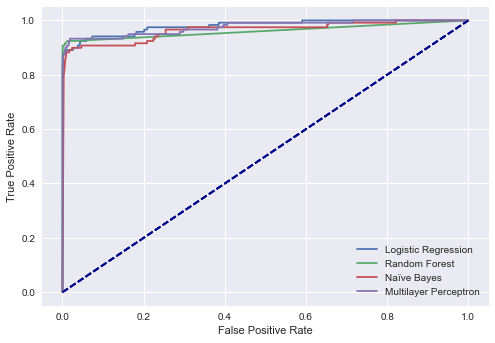

In [16]:
create_roc_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Logistic Regression")
#create_roc_curve(svc.predict_proba(X_test)[:,1], y_test, label="Support Vector Classifier")
create_roc_curve(rfc.predict_proba(X_test)[:,1], y_test, label="Random Forest")
create_roc_curve(nb.predict_proba(X_test)[:,1], y_test, label="Naïve Bayes")
create_roc_curve(mlp.predict_proba(X_test)[:,1], y_test, label="Multilayer Perceptron")

## Precicion Recall Curve

In [60]:
def plot_pr_cur(p, r, label="", title="plot title"):
    plt.plot(r, p, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    
def create_pr_curve(preds, targets, label="", title=""):
    all_p, all_r = [], []
    p, r, thresholds = precision_recall_curve(targets, preds)
    all_p.append(p)
    all_r.append(r)
    all_p = np.array(p)
    all_r = np.array(r)
    
    plot_pr_cur(all_p, all_r, label=label, title=title)

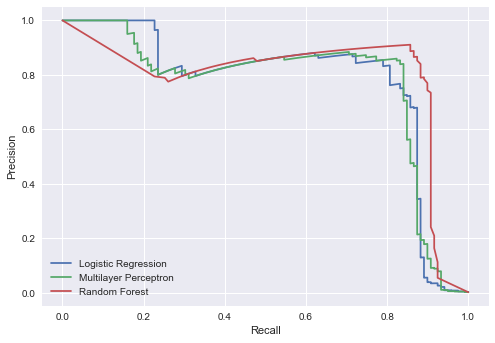

In [63]:
create_pr_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Logistic Regression")
create_pr_curve(mlp.predict_proba(X_test)[:,1], y_test, label="Multilayer Perceptron")
create_pr_curve(rfc.predict_proba(X_test)[:,1], y_test, label="Random Forest")
create_pr_curve(rfc.predict_proba(X_test)[:,1], y_test, label="Random Forest")

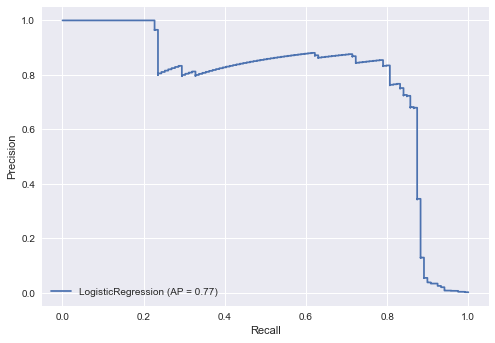

In [49]:
plot_precision_recall_curve(lrg, X_test, y_test)